In [1]:
from duckduckgo_search import DDGS
from itertools import islice
from fastcore.all import *

def search_images(term, max_images=30):
    with DDGS() as ddgs:
        vtr = []
        for r in islice(ddgs.images(term),max_images):
            vtr.append(r['image'])
        return vtr

In [2]:
urls = search_images("gato",3)
urls[0]

'http://upload.wikimedia.org/wikipedia/commons/1/1b/Gato_meditando.jpg'

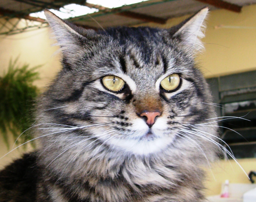

In [3]:
from fastdownload import download_url
dest = 'gato.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

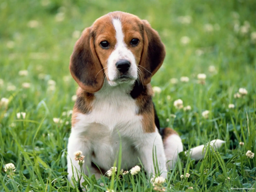

In [4]:
download_url(search_images('cachorro', max_images=1)[0], 'cachorro.jpg', show_progress=False)
Image.open('cachorro.jpg').to_thumb(256,256)

In [5]:
searches = 'gato','cachorro'
path = Path('gato_ou_cachorro')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(2)
    download_images(dest, urls=search_images(f'{o} no sol'))
    sleep(2)
    download_images(dest, urls=search_images(f'{o} no escuro'))
    sleep(2)
    resize_images(path/o, max_size=400, dest=path/o)
print("Carregado")

Carregado


In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

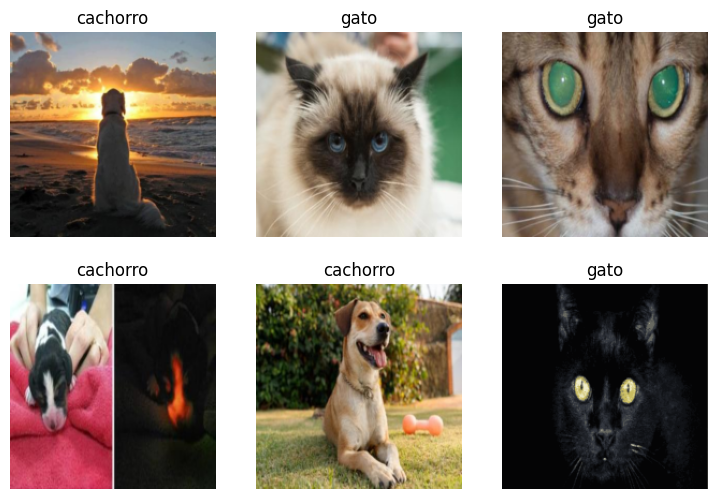

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/hellsank/projetos/machine_learn/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hellsank/projetos/machine_learn/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.600505,0.265368,0.109375,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.145254,0.020830,0.000000,00:04
1,0.104089,0.010365,0.000000,00:02
2,0.066568,0.024446,0.000000,00:02


In [9]:
e_gato ,_, probabilidade = learn.predict(PILImage.create('cachorro.jpg'))
print(f"Isto e um: {e_gato}.")
print(f"Chance de ser um gato: {probabilidade[1]:.4f}")

Isto e um: cachorro.
Chance de ser um gato: 0.0000


In [12]:
learn.export('model.pkl')